In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/CVF File/MRI Images/Training'
test_dir = '/content/drive/MyDrive/CVF File/MRI Images/Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [4]:
print("Total Training Images:", len(train_paths))
print("Total Testing Images:", len(test_paths))

Total Training Images: 5712
Total Testing Images: 1311


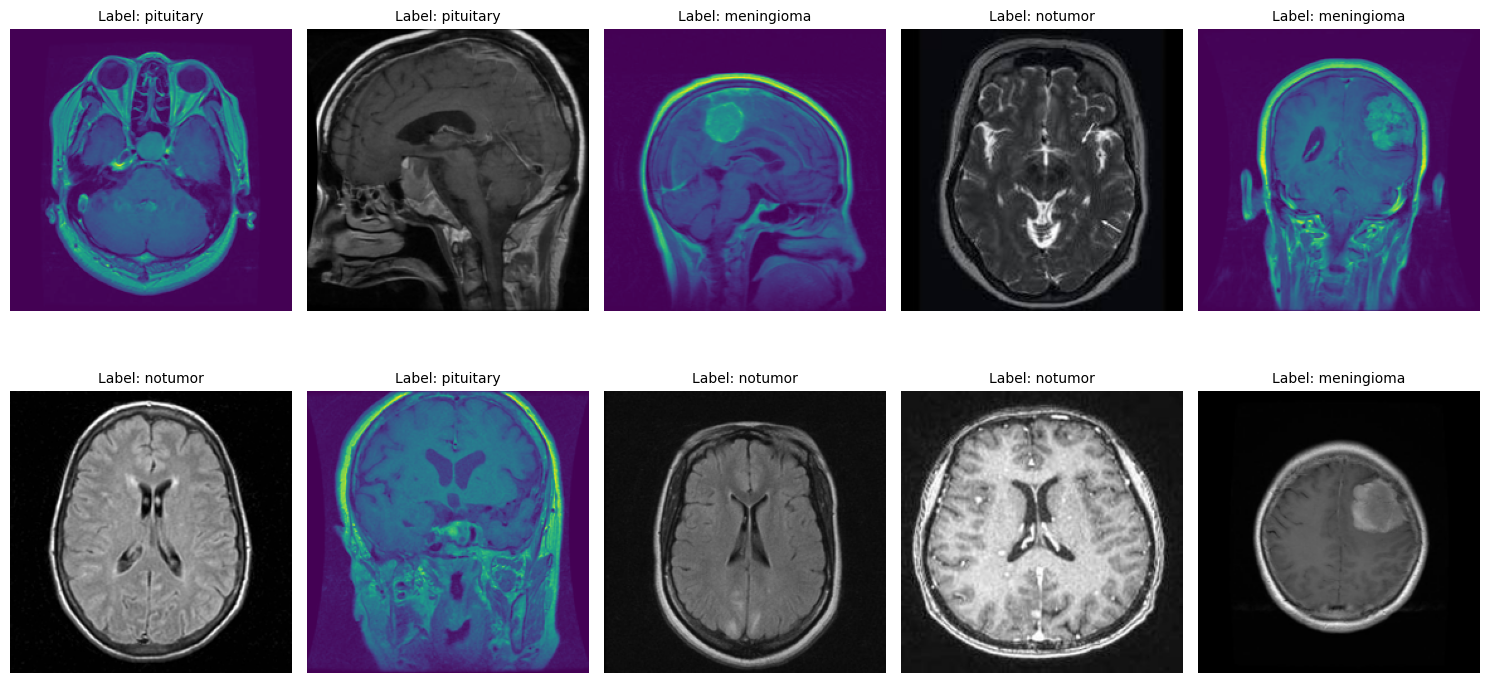

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [6]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

**MODEL : VGG16**

In [8]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')


for layer in base_model.layers:
    layer.trainable = False


base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1448s 5s/step - loss: 0.6029 - sparse_categorical_accuracy: 0.7627
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1393s 5s/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9049
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1402s 5s/step - loss: 0.1770 - sparse_categorical_accuracy: 0.9362
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1403s 5s/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9558
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1403s 5s/step - loss: 0.0753 - sparse_categorical_accuracy: 0.9734
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1403s 5s/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9820
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1400s 5s/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9789
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1399s 5s/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9859
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1399s 5s/step - loss: 0.0294 - sparse_categorical_acc

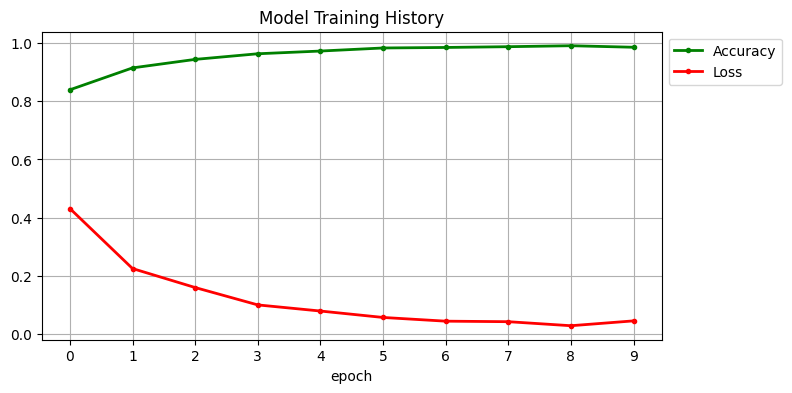

In [9]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       300
           1       1.00      1.00      1.00       405
           2       0.87      0.99      0.93       306
           3       1.00      0.84      0.92       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[297   0   3   0]
 [  1 404   0   0]
 [  4   0 302   0]
 [  4   2  41 253]]


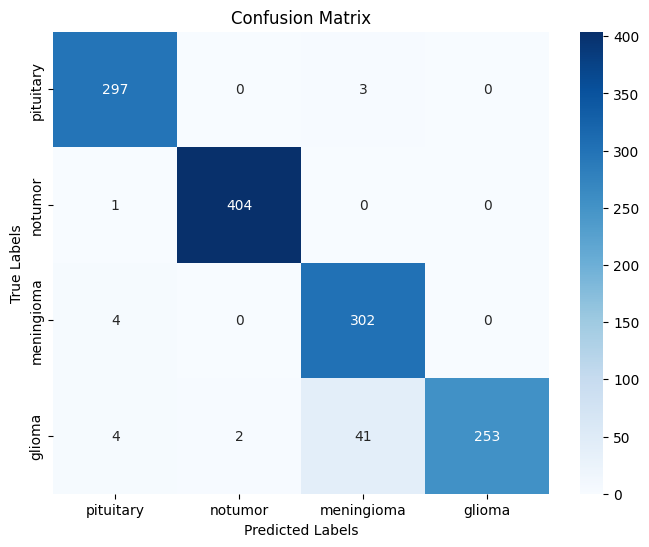

In [11]:
#  Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

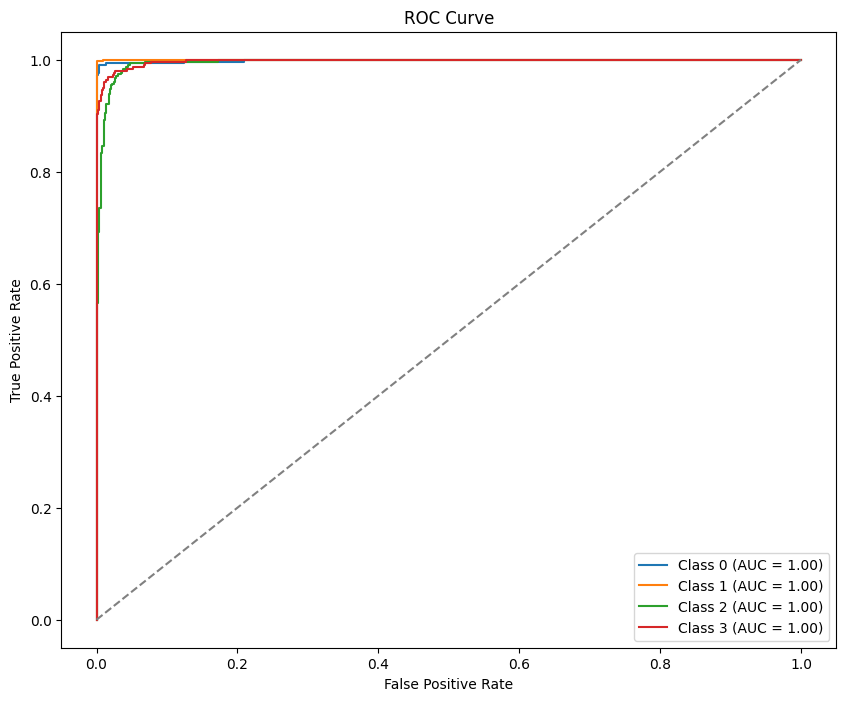

In [12]:
#  ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [13]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
          # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


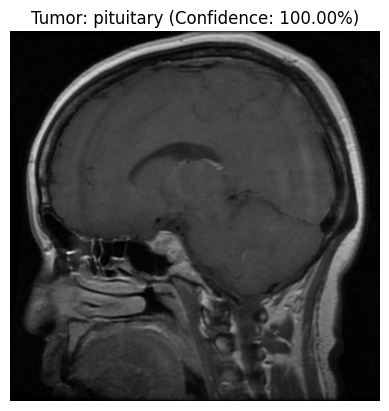

In [31]:
# Example usage
image_path = '/content/drive/MyDrive/CVF File/MRI Images/Testing/pituitary/Te-piTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [30]:


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Flatten, Dense, Dropout, Concatenate,
    LSTM, Reshape
)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


**Model RestNet50**

In [34]:
IMAGE_SIZE = 128
base_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model_resnet50 = Sequential()
model_resnet50.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_resnet50.add(base_model)
model_resnet50.add(Flatten())
model_resnet50.add(Dropout(0.3))
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

model_resnet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1422s 5s/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9877
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1406s 5s/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9914
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1403s 5s/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9934
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1402s 5s/step - loss: 0.0281 - sparse_categorical_accuracy: 0.9909
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1403s 5s/step - loss: 0.0107 - sparse_categorical_accuracy: 0.9977
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1407s 5s/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9959
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1405s 5s/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9908
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1405s 5s/step - loss: 0.0263 - sparse_categorical_accuracy: 0.9899
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 1408s 5s/step - loss: 0.0192 - sparse_categorical_acc

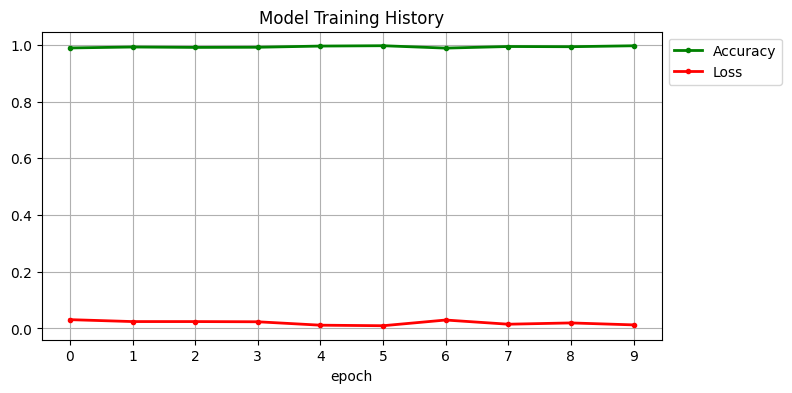

In [35]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 267s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       1.00      1.00      1.00       405
           2       0.95      0.98      0.96       306
           3       0.98      0.96      0.97       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



Confusion Matrix:
[[298   0   2   0]
 [  0 405   0   0]
 [  1   1 299   5]
 [  0   0  13 287]]


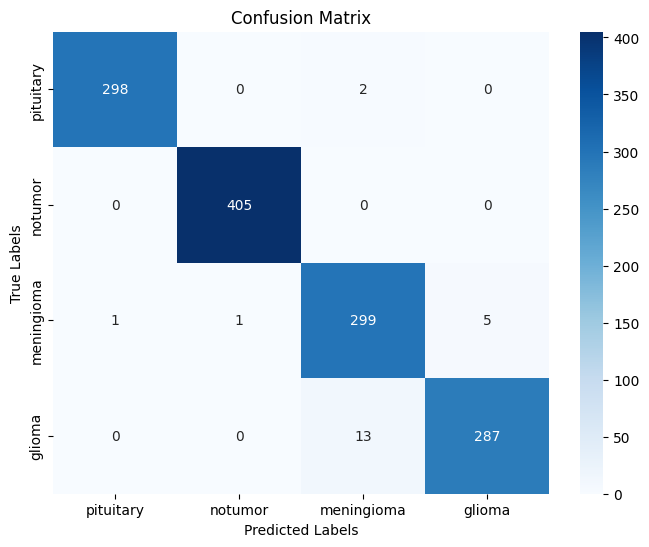

In [37]:
#  Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

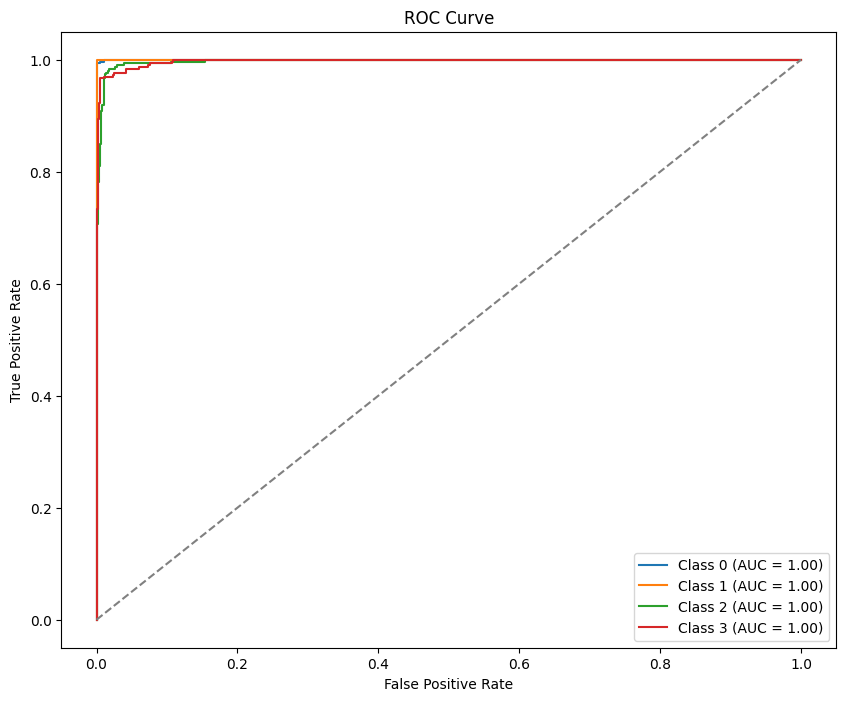

In [38]:
#  ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


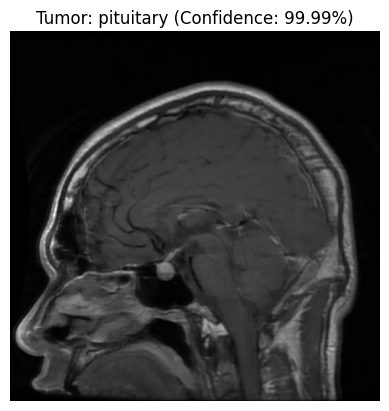

In [39]:
# Example usage
image_path = '/content/drive/MyDrive/CVF File/MRI Images/Testing/pituitary/Te-piTr_0006.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

**MobileNetV2**

In [40]:
IMAGE_SIZE = 128
base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')


for layer in base_model.layers:
    layer.trainable = False


base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 133s 435ms/step - loss: 0.6423 - sparse_categorical_accuracy: 0.7740
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 431ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.9424
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 122s 429ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9689
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 123s 433ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9772
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 416ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9839
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 121s 424ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9906
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 120s 420ms/step - loss: 0.0215 - sparse_categorical_accuracy: 0.9936
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 121s 425ms/step - loss: 0.0200 - sparse_categorical_accuracy: 0.9935
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 119s 419ms/step - loss: 0.0393 - sparse

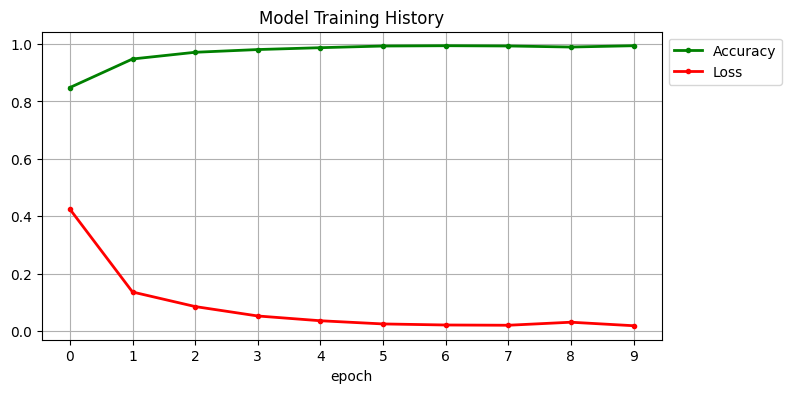

In [41]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       0.99      1.00      1.00       405
           2       0.88      0.97      0.92       306
           3       1.00      0.86      0.92       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[297   1   2   0]
 [  0 405   0   0]
 [  5   2 298   1]
 [  2   1  39 258]]


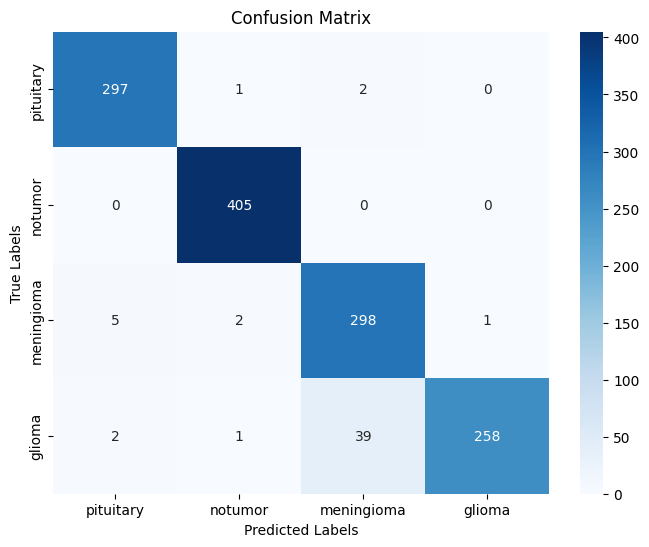

In [43]:
#  Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

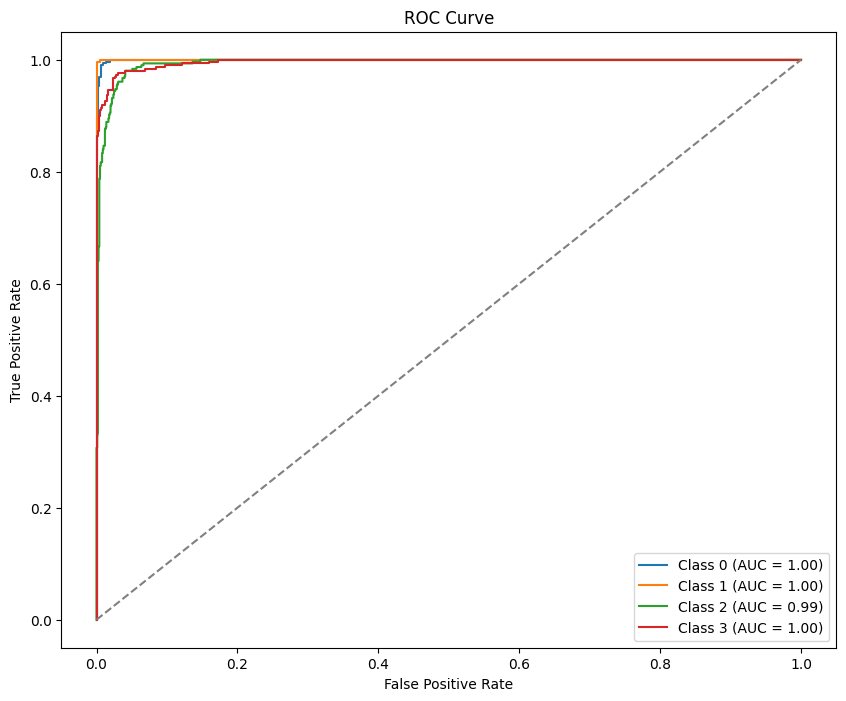

In [44]:
#  ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


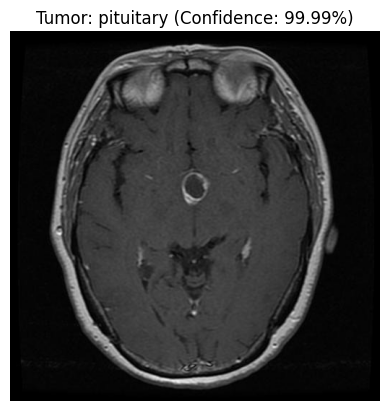

In [46]:
# Example usage
image_path = '/content/drive/MyDrive/CVF File/MRI Images/Testing/pituitary/Te-pi_0022.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

**U-net**

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model, Sequential

IMAGE_SIZE = 128

# --- Define U-Net Encoder Block ---
def unet_encoder(inputs):
    # Block 1
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    # Block 2
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Block 3 (Bottleneck for Classification)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    return c3

#  Build Model
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model_output = unet_encoder(inputs)

model_unet = Sequential()
model_unet.add(Model(inputs=inputs, outputs=base_model_output))
model_unet.add(Flatten())
model_unet.add(Dropout(0.3))
model_unet.add(Dense(128, activation='relu'))
model_unet.add(Dropout(0.2))
model_unet.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

model_unet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model_unet.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 174s 601ms/step - loss: 0.9550 - sparse_categorical_accuracy: 0.5846
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 163s 573ms/step - loss: 0.5105 - sparse_categorical_accuracy: 0.8085
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 164s 577ms/step - loss: 0.4104 - sparse_categorical_accuracy: 0.8448
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 163s 573ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.8758
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 163s 573ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.8896
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 164s 576ms/step - loss: 0.2505 - sparse_categorical_accuracy: 0.9065
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 164s 577ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9188
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 164s 575ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9373
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 164s 574ms/step - loss: 0.1748 - sparse_categorical_accuracy: 0.9413
Epoch 10/10
285/285

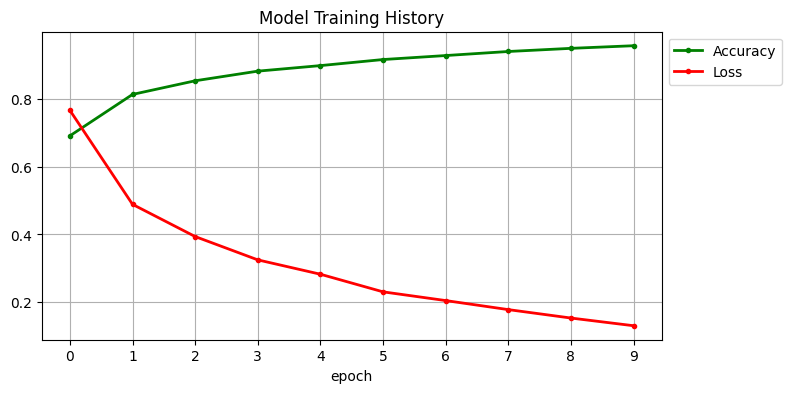

In [48]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 402ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       0.99      1.00      1.00       405
           2       0.88      0.98      0.93       306
           3       1.00      0.87      0.93       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[296   1   3   0]
 [  0 405   0   0]
 [  4   1 300   1]
 [  3   1  36 260]]


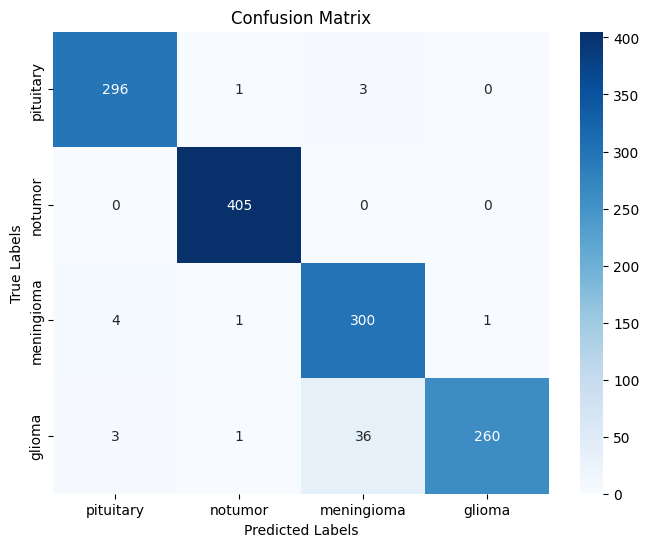

In [50]:
#  Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

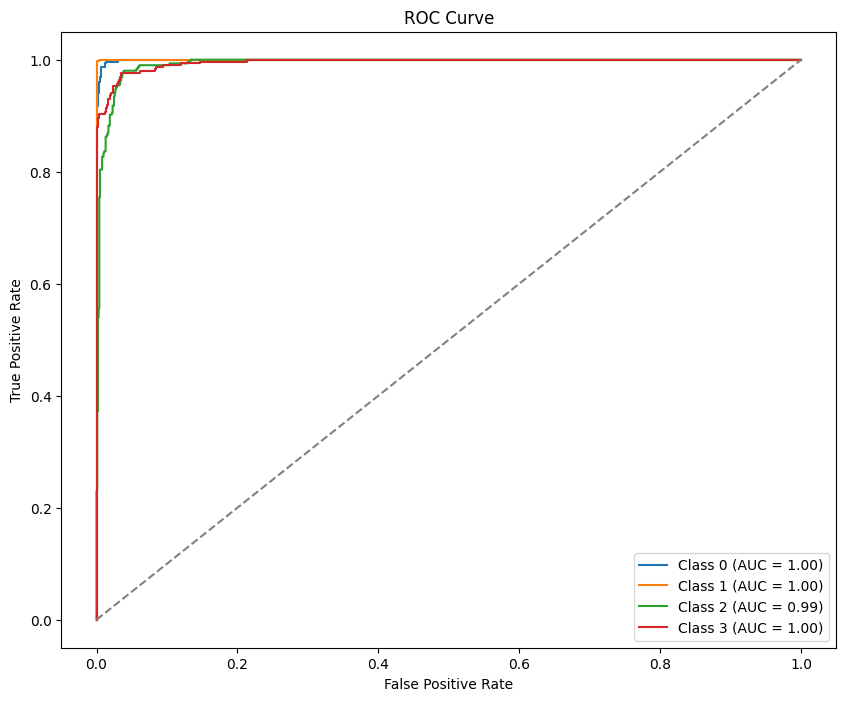

In [51]:
#  ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [52]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
          # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


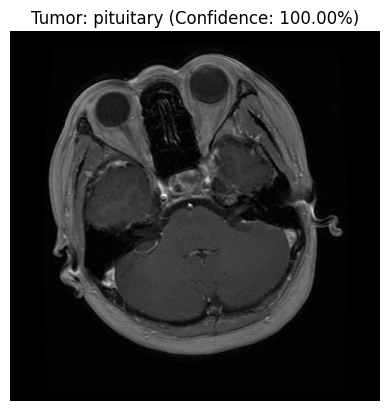

In [54]:
# Example usage
image_path = '/content/drive/MyDrive/CVF File/MRI Images/Testing/pituitary/Te-pi_0012.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

**Model: CNN + LSTM**

In [55]:
IMAGE_SIZE = 128

model_cnn_lstm = Sequential()
model_cnn_lstm.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

model_cnn_lstm.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling2D((2,2)))

model_cnn_lstm.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling2D((2,2)))

model_cnn_lstm.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling2D((2,2)))

model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Reshape((64, -1)))

model_cnn_lstm.add(LSTM(64))
model_cnn_lstm.add(Dropout(0.3))
model_cnn_lstm.add(Dense(128, activation='relu'))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

model_cnn_lstm.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 10

# Train the model
history_cnn_lstm = model_cnn_lstm.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    epochs=epochs,
    steps_per_epoch=steps
)


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 267s 919ms/step - loss: 1.3032 - sparse_categorical_accuracy: 0.3331
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 262s 920ms/step - loss: 0.9380 - sparse_categorical_accuracy: 0.6063
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 262s 919ms/step - loss: 0.7885 - sparse_categorical_accuracy: 0.6838
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 270s 948ms/step - loss: 0.7217 - sparse_categorical_accuracy: 0.6979
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 260s 912ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.7330
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 261s 916ms/step - loss: 0.6148 - sparse_categorical_accuracy: 0.7560
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 261s 917ms/step - loss: 0.6187 - sparse_categorical_accuracy: 0.7594
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 263s 921ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.7697
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 264s 924ms/step - loss: 0.5407 - sparse_categorical_accuracy: 0.7807
Epoch 10/10
285/285

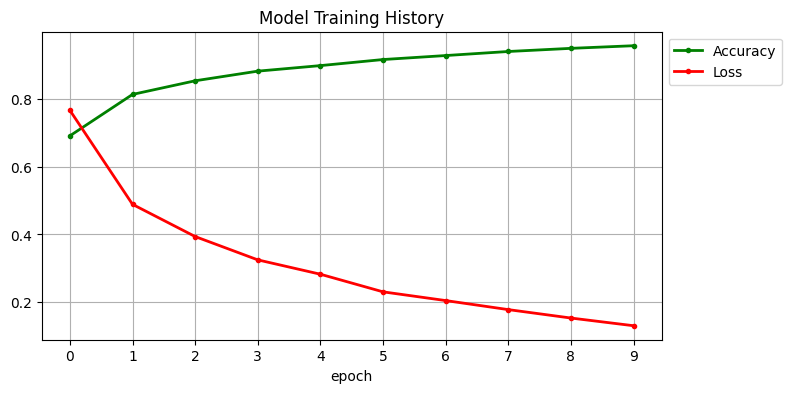

In [56]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 448ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       300
           1       1.00      1.00      1.00       405
           2       0.88      0.98      0.92       306
           3       1.00      0.86      0.93       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[296   1   3   0]
 [  0 405   0   0]
 [  5   1 299   1]
 [  2   0  39 259]]


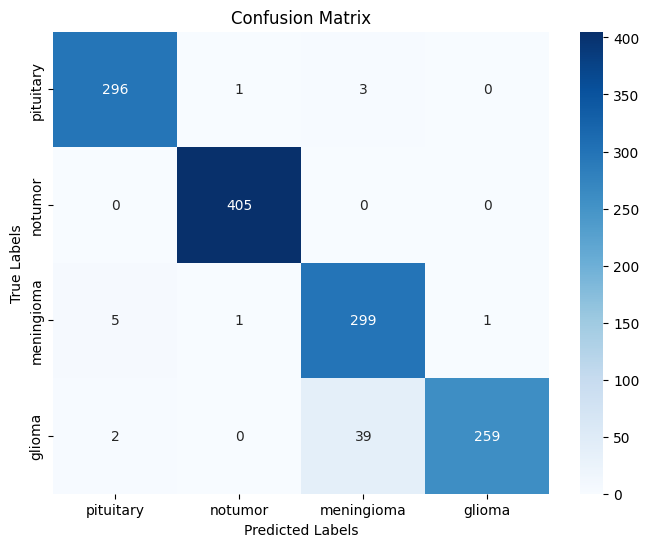

In [59]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

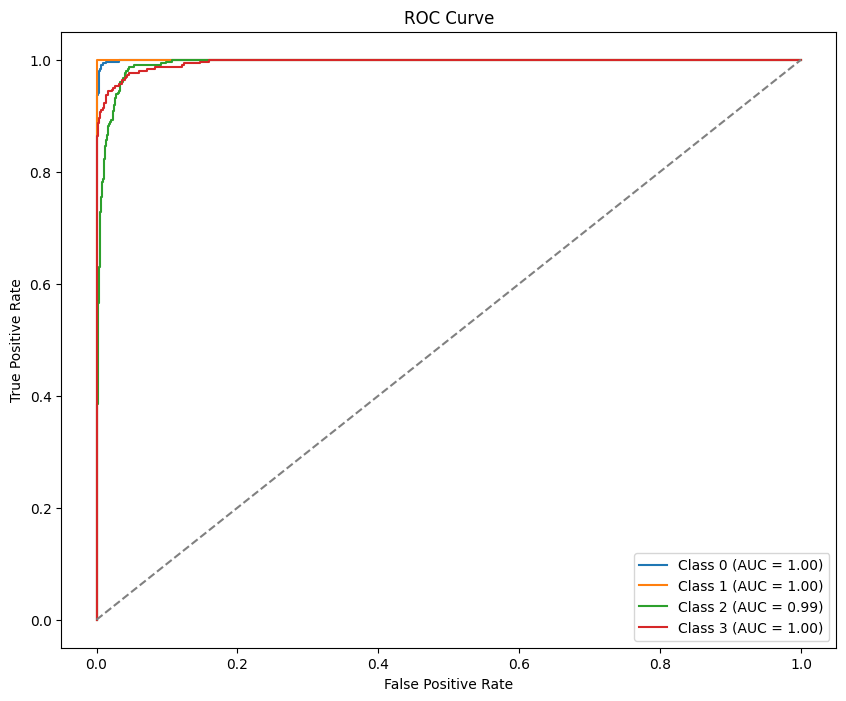

In [60]:
#  ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


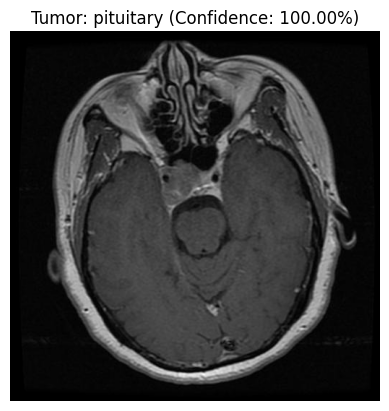

In [61]:
# Example usage
image_path = '/content/drive/MyDrive/CVF File/MRI Images/Testing/pituitary/Te-pi_0014.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)